# Exp 5. 캐글 경진대회 따라해보기

## [참여한 캐글 경진대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

### 1) Description
20개의 다양한 집의 가격을 결정하는 변수를 활용하여 어떤 조건을 가진 집의 가격이 높고 낮은 지를 예측하는 모델 만들기

### 2) Evaluation
RMSE(Root Mean Squared Error)

### 3) File description
train.csv : 학습 데이터 / 집의 정보와 예측할 변수인 '가격(price)' 변수를 가지고 있음
test.csv : 테스트 데이터 / 예측할 가격(price) 변수를 제외한 집의 정보를 가지고 있음
sample_submission.csv : 제출 시 사용할 수 있는 submission.csv 예시 파일

### 4) Data fields
ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 집의 가격(Target variable)  
bedrooms : 침실의 수  
bathrooms : 화장실의 수  
sqft_living : 주거 공간의 평방 피트(면적)  
sqft_lot : 부지의 평방 피트(면적)  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트(면적)  
sqft_basement : 지하실의 평방 피트(면적)  
yr_built : 지어진 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

# 1. 라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 2. 데이터 가져오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv') # 디렉토리 경로에 파일 이름을 조합하고 그 path를 리턴
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('슝')  # train, test 데이터 가져오기 완료!

슝


# 3. 데이터 확인하기

## 3-1. train 데이터

In [3]:
train.head()   # train 데이터 확인해보기

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train.shape   # train 데이터의 갯수, 컬럼 수

(15035, 21)

In [5]:
train.info()   # train 데이터의 각 컬럼 별 상세 내용

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
train.isnull().sum()   # train 데이터 내 결측치 없는 것 확인함

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 3-2. test 데이터

In [7]:
test.head()   # test 데이터 확인해보기

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [8]:
test.shape   # test 데이터의 갯수, 컬럼 수

(6468, 20)

In [9]:
test.info()   # test 데이터의 각 컬럼 별 상세 내용

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [10]:
test.isnull().sum()   # train 데이터 내 결측치 없는 것 확인함

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# 4. 데이터 전처리

## 4-1. price와 다른 feature과의 상관관계 확인
* target 데이터인 'price'와 가장 상관관계가 높은 상위 10개의 feature 값을 구함
* 스피어만 순위 상관관계를 히트맵으로 확인해봄

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

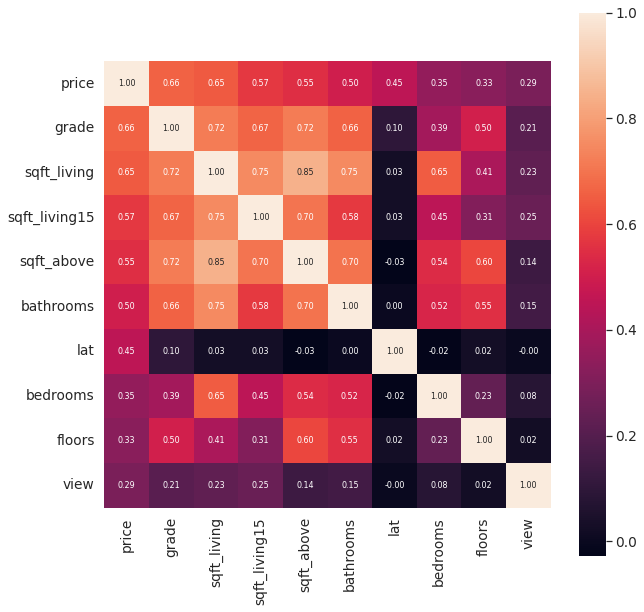

In [14]:
import scipy as sp

cor_abs = abs(train.corr(method = 'spearman'))
cor_cols = cor_abs.nlargest(n=10, columns = 'price').index
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)

plt.figure(figsize = (10, 10))
sns.set(font_scale = 1.25)
sns.heatmap(cor, fmt = '.2f', annot = True, square = True, annot_kws = {'size' : 8}, xticklabels = cor_cols.values, yticklabels = cor_cols.values)

* grade, sqft_living, sqft_living15, sqft_above, bathrooms, lat, bedrooms, floors, view 총 9개의 feature와 price와의 상관관계가 높은 것을 확인할 수 있었음
* 위의 feature들을 위주로 데이터 전처리를 할 예정

## 4-2. 각 feature 확인 및 이상치 처리

### 4-2-1. grade
* 3등급의 값이 유난히 큼
* 7, 8, 11등급에 큰 이상치가 있음  
▶▶ 3, 7, 8, 11등급에 있는 이상치를 제거

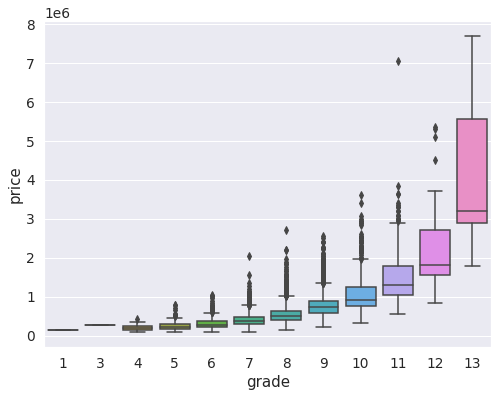

In [15]:
data = pd.concat([train['price'], train['grade']], axis = 1)

f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x = 'grade', y = 'price', data = data)

In [16]:
 train.loc[(train['price'] > 12) & (train['grade'] == 3)]  # 3등급의 이상치 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,262000.0,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,280000.0,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [17]:
train.loc[(train['price'] > 14.3) & (train['grade'] == 7)]  # 7등급의 이상치 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15005,15005,20140513T000000,330000.0,3,2.50,1450,5008,1.0,0,0,...,7,840,610,2007,0,98106,47.5435,-122.357,2120,5019
15011,15011,20140623T000000,362500.0,2,1.50,940,1768,2.0,0,0,...,7,940,0,2009,0,98144,47.5925,-122.295,1130,1159
15015,15015,20140610T000000,399950.0,2,1.00,710,1157,2.0,0,0,...,7,710,0,1943,0,98102,47.6413,-122.329,1370,1173
15016,15016,20140828T000000,270000.0,3,2.50,1870,5000,2.0,0,0,...,7,1870,0,2009,0,98042,47.3339,-122.055,2170,5399


In [18]:
train.loc[(train['price'] > 14.7) & (train['grade'] == 8)]  # 8등급의 이상치 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
18,18,20141120T000000,329000.0,3,2.25,2450,6500,2.0,0,0,...,8,2450,0,1985,0,98030,47.3739,-122.172,2200,6865
20,20,20140626T000000,937000.0,3,1.75,2450,2691,2.0,0,0,...,8,1750,700,1915,0,98119,47.6386,-122.360,1760,3573
21,21,20141201T000000,667000.0,3,1.00,1400,1581,1.5,0,0,...,8,1400,0,1909,0,98112,47.6221,-122.314,1860,3861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15023,15023,20141017T000000,350000.0,4,2.75,2500,5995,2.0,0,0,...,8,2500,0,2008,0,98042,47.3749,-122.107,2530,5988
15028,15028,20150407T000000,467000.0,3,2.50,1425,1179,3.0,0,0,...,8,1425,0,2008,0,98125,47.6963,-122.318,1285,1253
15029,15029,20140825T000000,507250.0,3,2.50,2270,5536,2.0,0,0,...,8,2270,0,2003,0,98065,47.5389,-121.881,2270,5731
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509


In [19]:
train.loc[(train['price'] > 15.5) & (train['grade'] == 11)]  # 11등급의 이상치 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
47,47,20140912T000000,1040000.0,5,3.25,4770,50094,1.0,0,0,...,11,3070,1700,1973,0,98005,47.6525,-122.160,3530,38917
191,191,20150504T000000,2900000.0,4,3.25,5050,20100,1.5,0,2,...,11,4750,300,1982,2008,98004,47.6312,-122.223,3890,20060
192,192,20141007T000000,1365000.0,4,4.75,5310,57346,2.0,0,0,...,11,5310,0,1989,0,98077,47.7285,-122.042,4180,47443
222,222,20140618T000000,1384000.0,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
275,275,20140728T000000,1350000.0,5,3.50,4800,14984,2.0,0,2,...,11,3480,1320,1998,0,98006,47.5543,-122.148,4050,19009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,14975,20140617T000000,1325000.0,4,4.00,4420,16526,2.0,0,0,...,11,4420,0,2013,0,98075,47.5914,-122.027,3510,50447
14988,14988,20140819T000000,1057000.0,2,1.50,2370,184231,2.0,0,0,...,11,2370,0,2005,0,98045,47.4543,-121.778,3860,151081
14990,14990,20141224T000000,1375000.0,5,4.50,4350,13405,2.0,0,0,...,11,4350,0,2014,0,98074,47.6018,-122.060,3990,7208
15021,15021,20140514T000000,1222500.0,4,3.50,4910,9444,1.5,0,0,...,11,3110,1800,2007,0,98074,47.6502,-122.066,4560,11063


In [20]:
# 위의 이상치들 모두 제거

train = train.drop([train.index[2775], train.index[2302], train.index[4123], train.index[12346], train.index[983], train.index[7173], train.index[10037]])

In [21]:
# 이상치가 잘 제거가 되었는지 하나의 값으로 확인

train.loc[(train['price'] > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
47,47,20140912T000000,1040000.0,5,3.25,4770,50094,1.0,0,0,...,11,3070,1700,1973,0,98005,47.6525,-122.160,3530,38917
191,191,20150504T000000,2900000.0,4,3.25,5050,20100,1.5,0,2,...,11,4750,300,1982,2008,98004,47.6312,-122.223,3890,20060
192,192,20141007T000000,1365000.0,4,4.75,5310,57346,2.0,0,0,...,11,5310,0,1989,0,98077,47.7285,-122.042,4180,47443
222,222,20140618T000000,1384000.0,4,3.25,4290,12103,1.0,0,3,...,11,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244
275,275,20140728T000000,1350000.0,5,3.50,4800,14984,2.0,0,2,...,11,3480,1320,1998,0,98006,47.5543,-122.148,4050,19009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,14975,20140617T000000,1325000.0,4,4.00,4420,16526,2.0,0,0,...,11,4420,0,2013,0,98075,47.5914,-122.027,3510,50447
14988,14988,20140819T000000,1057000.0,2,1.50,2370,184231,2.0,0,0,...,11,2370,0,2005,0,98045,47.4543,-121.778,3860,151081
14990,14990,20141224T000000,1375000.0,5,4.50,4350,13405,2.0,0,0,...,11,4350,0,2014,0,98074,47.6018,-122.060,3990,7208
15021,15021,20140514T000000,1222500.0,4,3.50,4910,9444,1.5,0,0,...,11,3110,1800,2007,0,98074,47.6502,-122.066,4560,11063


### 4-2-2. sqft_living
* 그래프를 그려보았을 때, 멀리 떨어져있는 이상치를 발견
* 해당 이상치 제거

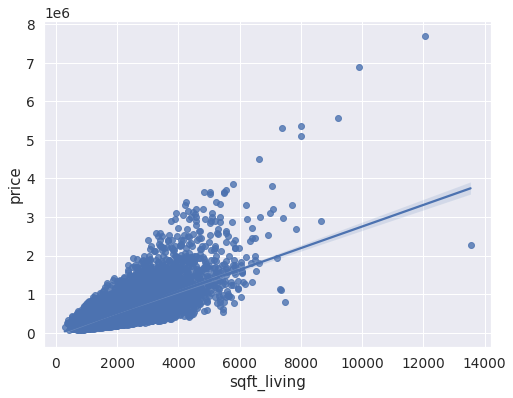

In [22]:
data = pd.concat([train['price'], train['sqft_living']], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.regplot(x = 'sqft_living', y = 'price', data = data)

In [23]:
train.loc[train['sqft_living'] > 13000]   # 이상치 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [24]:
train = train.loc[train['id'] != 8912]   # 이상치 제거

In [25]:
train.loc[train['sqft_living'] > 13000]  # 이상치가 정상적으로 제거되었는지 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### 4-2-3. id
* id는 불필요하다고 판단되어 제거
* train, test 데이터 모두 제거

In [26]:
del train['id']
del test['id']

print(train.columns)
print(test.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [27]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [28]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 4-2-4. date
* 날짜 뒤의 시간 등 불필요한 정보 제거
* train, test 데이터 모두 제거

In [29]:
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)

In [30]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [31]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 4-2-5. target 데이터(price)
* price의 값이 한쪽으로 치우친 데이터임을 확인
* 정규화를 통해 정규분포가 되도록 만들어 줌  
* price와 다른 feature들 간의 상관관계를 파악하였으니 이제 y 변수에 새롭게 할당
* train 데이터에서는 price 컬럼을 제거

In [32]:
train['price']

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15027, dtype: float64

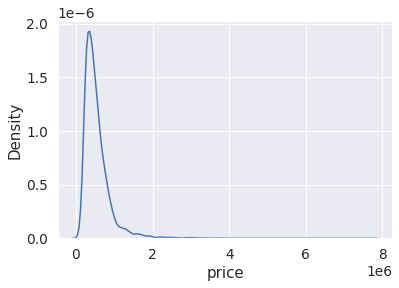

In [33]:
# seaborn의 'kdeplot'을 활용해 price의 분포 확인
sns.kdeplot(train['price'])
plt.show()

# price 값이 왼쪽으로 크게 치우쳐 있음
# np.log1p() 함수를 통해 로그 변환
# 모델이 값을 예측한 후 np.expm1() 함수를 활용해 되돌리기

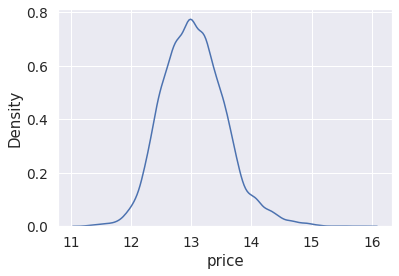

In [34]:
# # np.log1p()함수를 통해 로그 변환

train['price'] = np.log1p(train['price'])
train['price']

sns.kdeplot(train['price'])
plt.show()
# 정규분포의 형태로 잘 변환됨

In [35]:
y = train['price']
del train['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 4-3. 변수 분포 확인

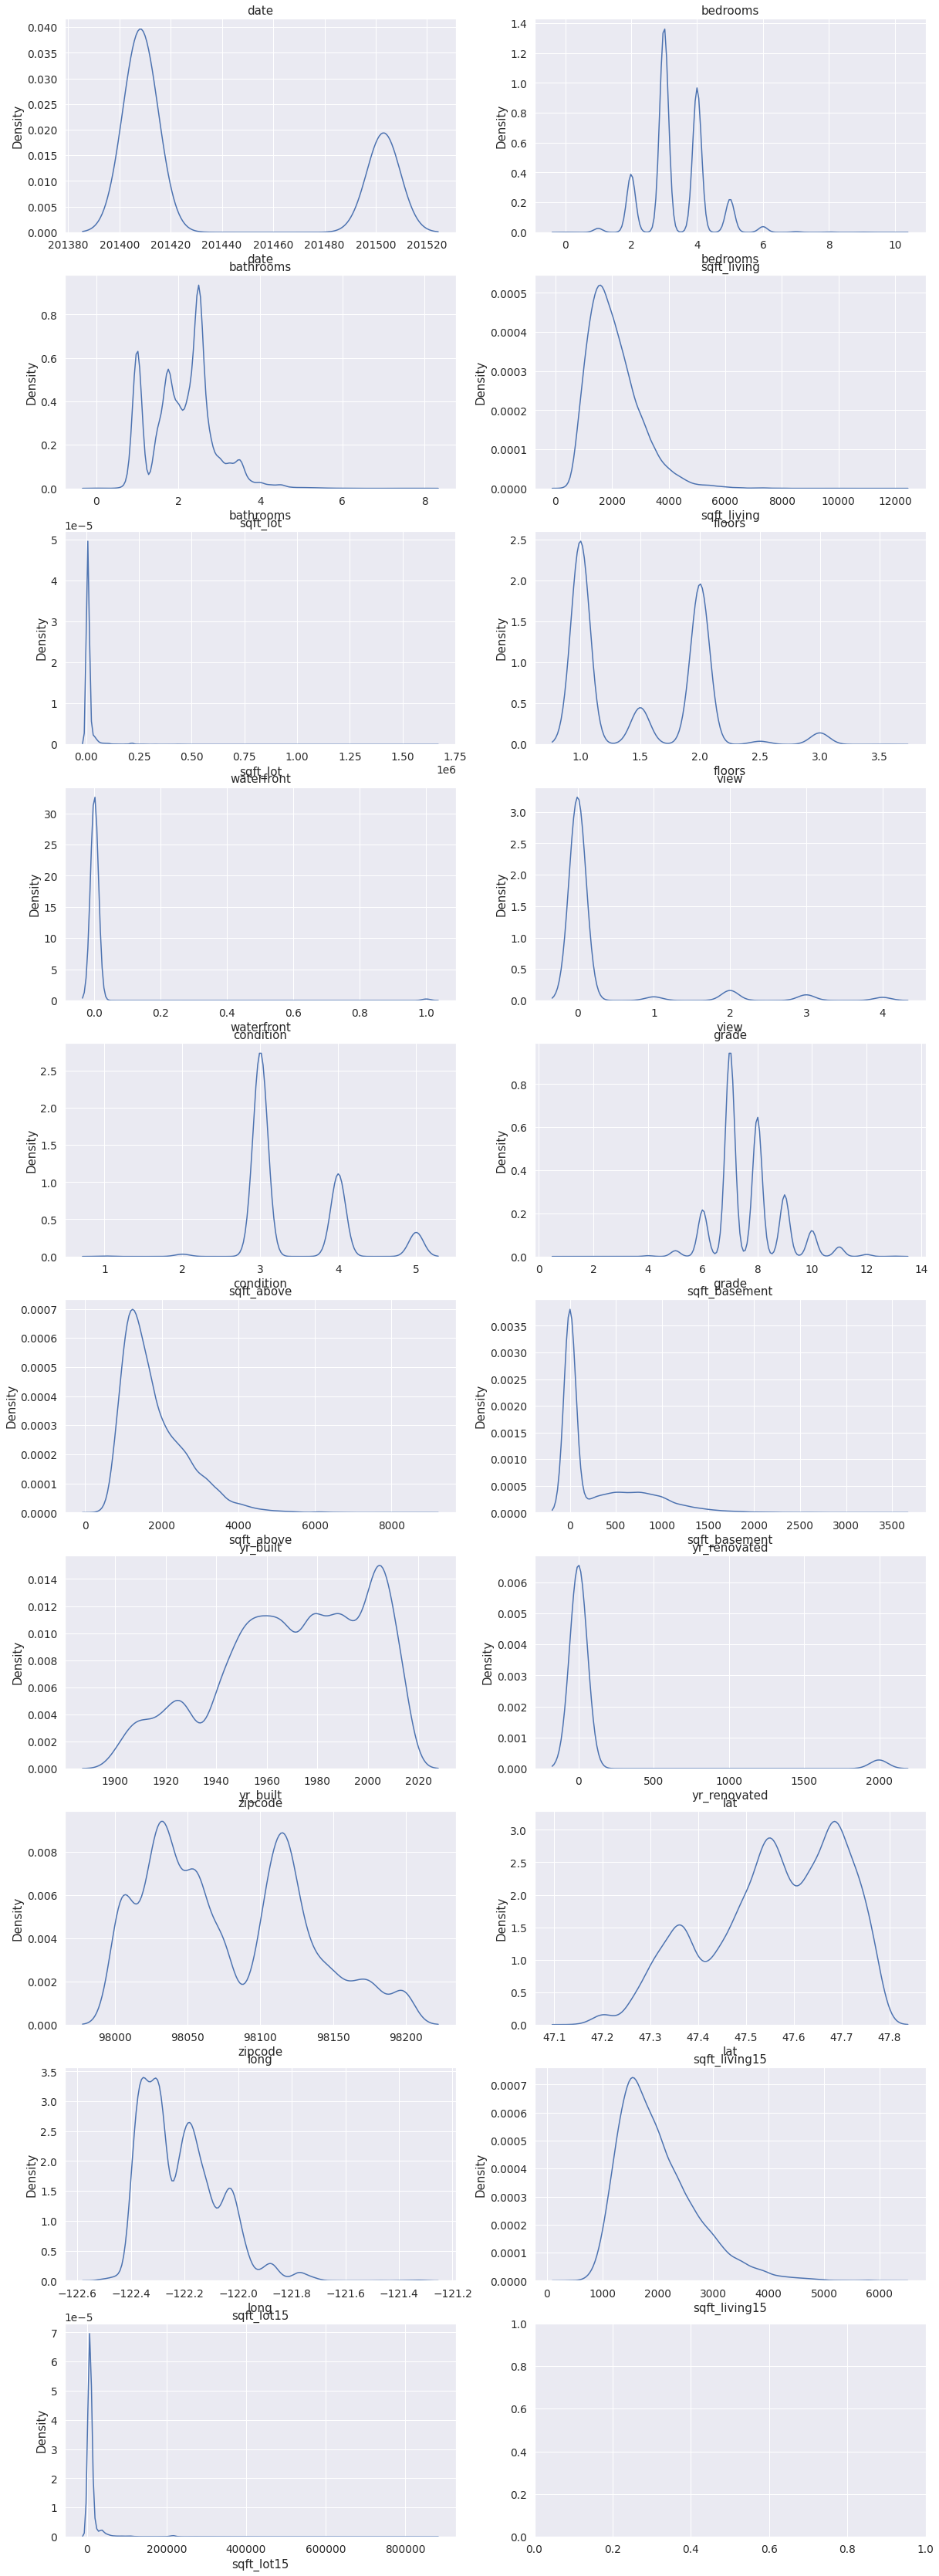

In [36]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

* waterfront, view : 유무와 정도를 나타낸 feature이기에 정규분포화하지 않아도 됨
* yr_renovated : 0(하지 않음)과 년도를 나타낸 feature이기에 정규분포화하지 않아도 됨

## 4-4. 변수 정규분포화

In [37]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

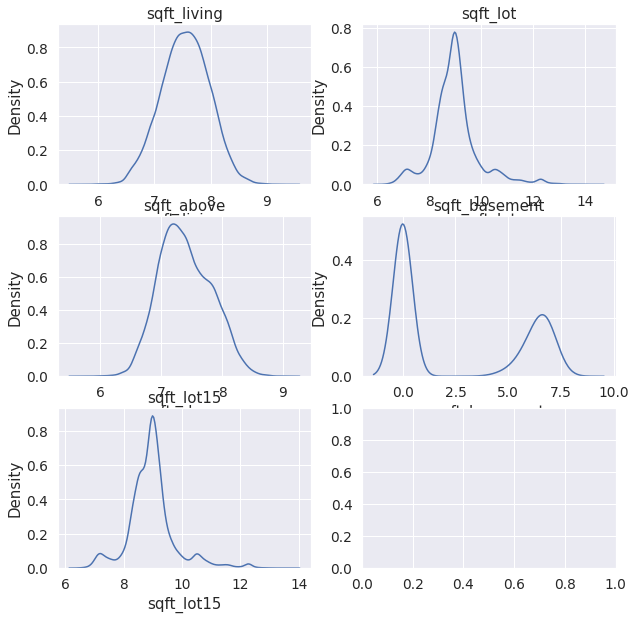

In [38]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count = 0

for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

# 5. 모델링

## 5-1. 모델 튜닝

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('슝')

슝


In [44]:
random_state = 200

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [45]:
#각 모델들의 RMSE 확인
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,141706.901104
RandomForestRegressor,132183.579017
XGBRegressor,116006.714713
LGBMRegressor,114202.433884


## 5-2. LGBRegressor

In [46]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    grid_model = GridSearchCV(model,param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1, n_jobs = 5)
    
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [47]:
# 파라미터 선정

param_grid = {
    'n_estimators' : [50, 100],
    'max_depth' : [1, 10]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.026910,0.164044
2,10,50,-0.029108,0.170611
1,1,100,-0.054957,0.234430
0,1,50,-0.073135,0.270434


In [48]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)

In [49]:
prediction = np.expm1(prediction)
prediction

array([ 516817.94390453,  452224.88862842, 1326363.07593154, ...,
        458393.53110881,  329764.49525547,  433838.30700807])

In [50]:
#샘플 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [51]:
#모델이 예측 한 값을 샘플 데이터에 덮어 씌우고 저장
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.168179e+05
1,15036,4.522249e+05
2,15037,1.326363e+06
3,15038,3.119938e+05
4,15039,3.257986e+05


In [52]:
# submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164044')
# submission.to_csv(submission_csv_path, index=False)
# print(submission_csv_path)

### [LGBRegressor] 모델 결과

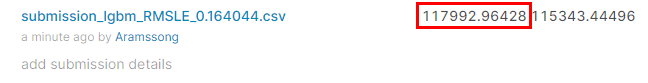

## 5-3. XGBRegressor

[[KaKR 2nd House Price] XGB Starter (~109145)](https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145)  
위의 코드를 참고함

In [53]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv') # 디렉토리 경로에 파일 이름을 조합하고 그 path를 리턴
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('슝')  # train, test 데이터 가져오기 완료!

슝


In [54]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [55]:
test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [56]:
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)

In [57]:
del train['id']
del test['id']

In [58]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [59]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [60]:
y_train = train['price']
x_train = train
x_test = test

In [61]:
index = x_train.shape[0]
df = pd.concat([x_train, x_test], axis=0)

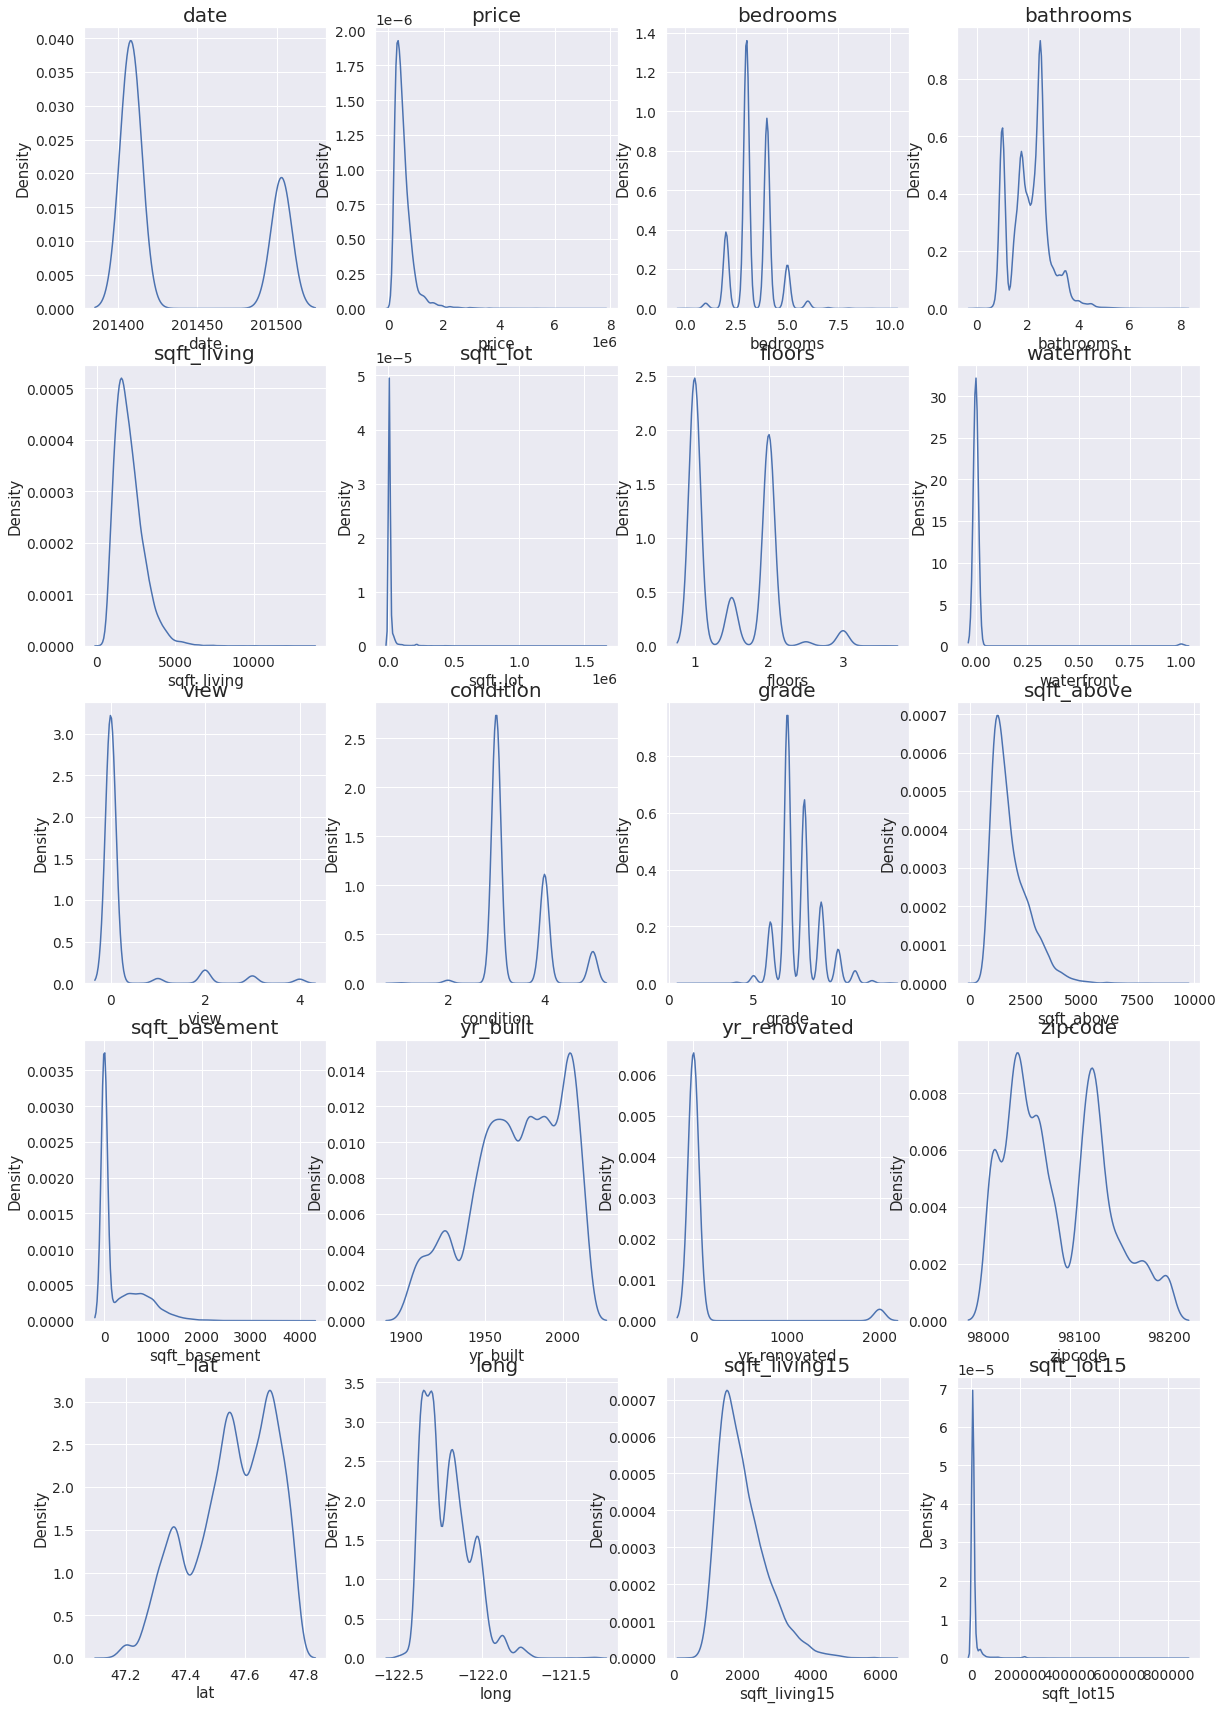

In [62]:
x_train = df.iloc[:index, :]
x_test = df.iloc[index:, :]

x_train.shape, x_test.shape

fig, ax = plt.subplots(5, 4, figsize=(20, 30))
n = 0
cols = x_train.columns
for r in range(5):
    for c in range(4):
        sns.kdeplot(x_train[cols[n]], ax=ax[r][c])
        ax[r][c].set_title(cols[n], fontsize=20)
        n += 1
        if n == x_train.shape[1]:
            break

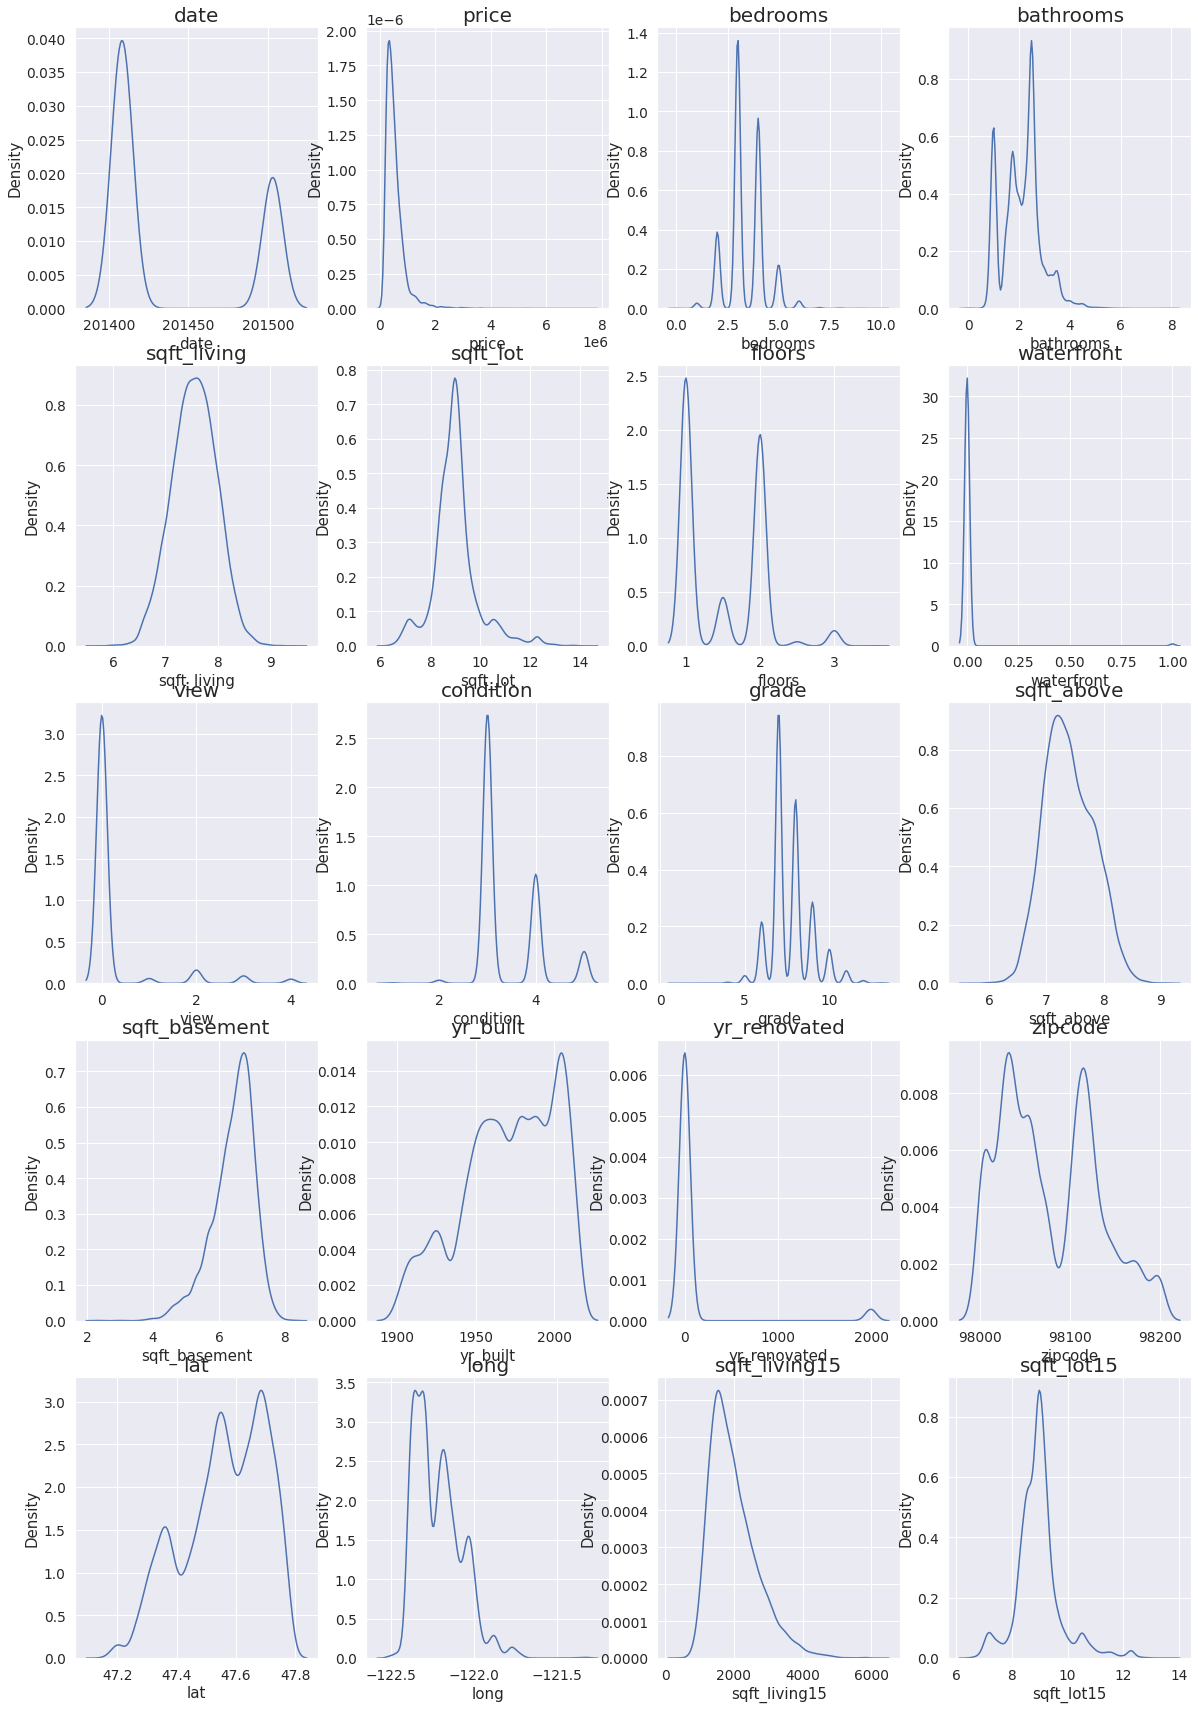

In [63]:
def preprocessing(df):
    
    df.sqft_living = np.log(df.sqft_living)
    df.sqft_lot = np.log(df.sqft_lot)
    df.sqft_above = np.log(df.sqft_above)
    df.sqft_basement = np.log(df.sqft_basement)
    df.sqft_lot15 = np.log(df.sqft_lot15)
    
#     df['roomsum'] = np.log(df.bedrooms + df.bathrooms)
#     df['roomsize'] = df.sqft_living / df.roomsum
    
#     df['pos'] = df.long.astype(str) + ', ' + df.lat.astype(str)
#     df['density'] = df.groupby('pos')['pos'].transform('count')
    
#     df = df.drop(['pos'], axis=1)
    
    return df

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)

fig, ax = plt.subplots(5, 4, figsize=(20, 30))
n = 0
cols = x_train.columns
for r in range(5):
    for c in range(4):
        sns.kdeplot(x_train[cols[n]], ax=ax[r][c])
        ax[r][c].set_title(cols[n], fontsize=20)
        n += 1
        if n == x_train.shape[1]:
            break

In [64]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

Transform DMatrix...


XGBoostError: [08:51:09] ../src/data/data.cc:945: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7f1e73ec433f]
  [bt] (1) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x14e930) [0x7f1e73f81930]
  [bt] (2) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x15f8ff) [0x7f1e73f928ff]
  [bt] (3) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x156cf5) [0x7f1e73f89cf5]
  [bt] (4) /opt/conda/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(XGDMatrixCreateFromMat_omp+0x7c) [0x7f1e73ebc04c]
  [bt] (5) /opt/conda/lib/python3.9/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f1f046c0a4a]
  [bt] (6) /opt/conda/lib/python3.9/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f1f046bffea]
  [bt] (7) /opt/conda/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x13dc7) [0x7f1f046d9dc7]
  [bt] (8) /opt/conda/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x14454) [0x7f1f046da454]



In [ ]:
# model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
# preds = model.predict(dtest)

# sub = test[['id']]
# sub['price'] = preds
# sub.to_csv('sub_xgb_starter.csv', index=False)

---

# 회고

### 1) 데이터 전처리
* 데이터 전처리 시 데이터를 이해하고 특성을 파악하여 그에 맞춰 진행하는 것이 중요하다고 알게 되었다.
* 예측값과의 상관관계를 확인하여 상관관계가 높은 데이터를 위주로 전처리를 진행하였다. 하지만 내가 전처리한 데이터 이외에도 무수히 많이 데이터를 조합하고 전처리를 할 수 있는 방법이 많다는 것을 알게 되었고 그것들을 녹여내지 못한 것이 많이 아쉬웠다.

### 2) 모델링
* 모델을 튜닝할 때 각 모델들의 RMSE도 어떨 때는 높게 나오고 어떨 때는 낮게 나왔다. 그래서 모델들의 RMSE를 어떻게 하면 낮출 수 있을까 생각을 해보았는데 좀 더 고민할 문제라고 생각된다.
* 여러 모델들을 사용하여 결과값을 내려고 하였으나 실패했다..

#### (1) LGBRegressor
* LMS에 있는 파라미터 이외의 다른 파라미터들 (주로 사용되는 파라미터)를 추가하여 모델링을 하였는데, RMSLE 최소값이 0.2였다. 그래서 결국 LMS에 있는 파라미터만을 사용하였고 그 결과, RMSLE는 0.164044가 나왔다.
* 하이퍼파라미터에 대해 더 공부하고 다시 시도해볼 필요가 있다.

#### (2) XGBRegressor
* 다른 사람이 올린 코드를 보고 열심히 따라해보았으나 결국 에러가 났다.
* 에러 없이 한번은 정상적으로 그래프도 나오고 되었으나 그 이후엔 계속 에러가 발생하여 실패했다.
* Check failed: valid: Input data contains `inf` or `nan`
* 해당 에러에 대해 확인해보고 input data를 이것저것 변경해보았지만 계속 에러가 발생했다.

#### (3) Average Blending
Average Blending을 진행했을 때, 오히려 더 private score가 낮게 나왔다..(다른 파일에서 진행)
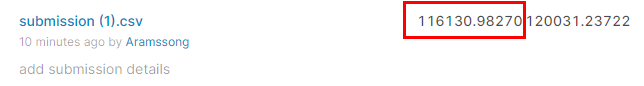

### 3) 후기
* 이번 프로젝트를 진행하면서 다양한 코드를 접하게 되었다. 같은 데이터의 결과값을 예측하는 데도 이렇게 다양한 방법이 사용될 수 있다는 것을 알게 되었다.  
* 현재 나의 실력만으로 데이터 전처리부터 모델링까지 하기 힘들다는 것을 깨닫고 다른 사람이 작성한 코드를 참고하였다.  
* 여러 코드 중 내가 이해한 부분을 위주로 코드를 작성하였고 여러 코드를 접목시켜보았다.  
* 이 프로젝트 이후에는 내가 이해하지 않은 부분들도 코드를 반복해서 보고 직접 따라해보며 이해해보려고 한다.

### 4) 시도해볼 것

1. 데이터 전처리 다양한 방법으로 진행 (여러 feature 전처리)
2. 모델들의 RMSE을 낮출 수 있는 방법 찾아보기
3. LGBRegressor에서 다른 하이퍼파라미터 사용해보기
4. XGBRegressor를 다시 한번 도전해보기
5. 다른 모델로도 진행해보기

# 참고 (Reference)

* 데이터 전처리 : https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
* XGBRegressor : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145Z